In [1]:
DIRECTORY = "/home/saint/datasets/competitions/tgs-salt-identification-challenge"
SAVE_PATH = "/home/saint/models/salt"
WEIGHTS_PATH = "/home/saint/weights/ternaus_net_v2_deepglobe_buildings.pt"

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data

from torchvision.transforms import ToTensor, Normalize, Compose

from src.utils import *
from src.components.TernausNetV2 import *

from IPython.core.debugger import set_trace

In [3]:
import os, cv2, glob
import numpy as np
import pandas as pd
from pathlib import Path
from torch.autograd import Variable
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import jaccard_similarity_score
from collections import OrderedDict

from pylab import *
import random
from skimage.morphology import watershed
import scipy.ndimage as ndimage
from PIL import Image, ImagePalette

import tifffile as tiff

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline

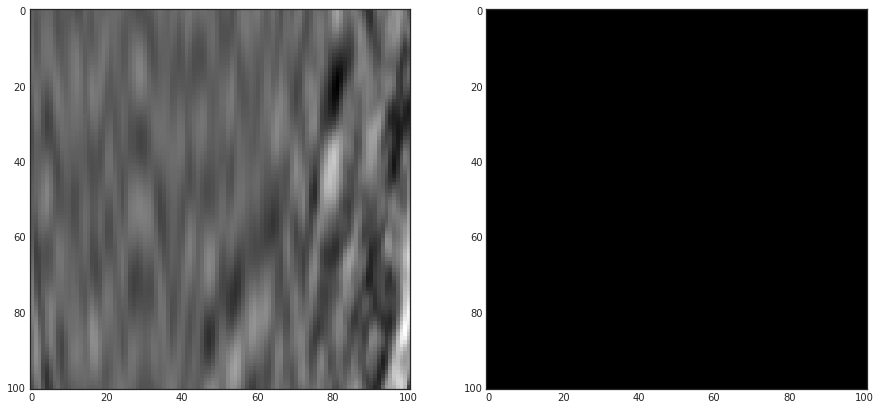

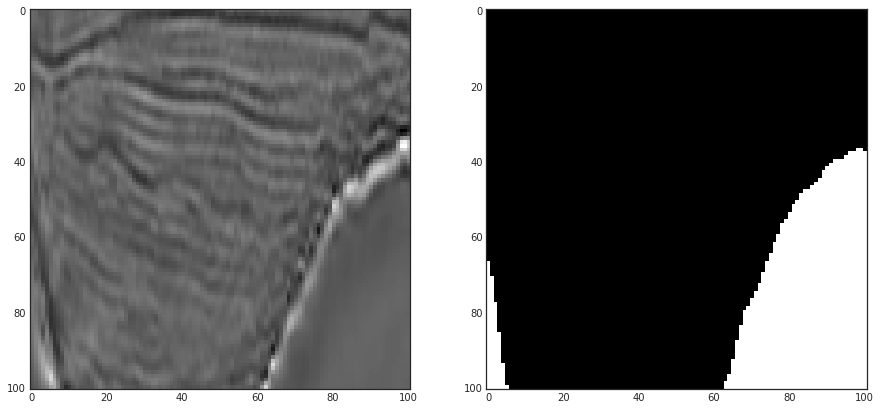

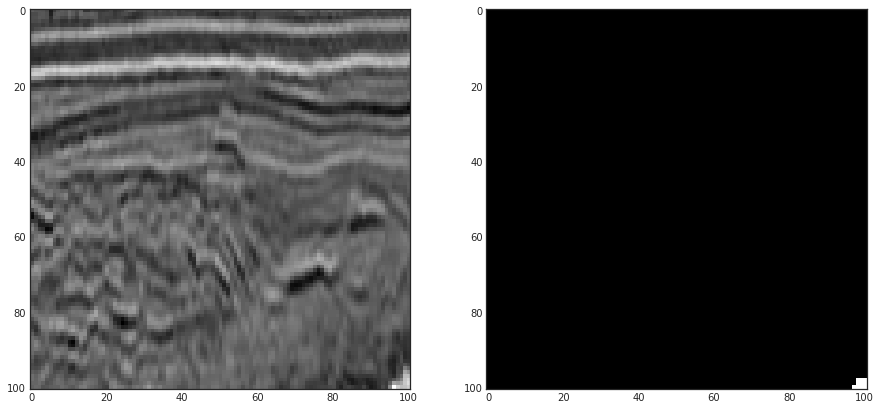

In [4]:
ids= ['1f1cc6b3a4','5b7c160d0d','6c40978ddf'] #,'7dfdf6eeb8','7e5a6e5013']
def show(ids):
    for j, img_name in enumerate(ids):
        q = j + 1
        img = cv2.imread(DIRECTORY + '/train/images/' + img_name + '.png')
        img_mask = cv2.imread(DIRECTORY + '/train/masks/' + img_name + '.png')

        plt.figure(figsize=(15,10))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.subplot(1, 2, 2)
        plt.imshow(img_mask)
    plt.show()
show(ids)

In [5]:
def load_image(path, mask = False):
    """
    Load image from a given path and pad it on the sides, so that eash side is divisible by 32 (newtwork requirement)
    
    if pad = True:
        returns image as numpy.array, tuple with padding in pixels as(x_min_pad, y_min_pad, x_max_pad, y_max_pad)
    else:
        returns image as numpy.array
    """
    img = cv2.imread(str(path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, _ = img.shape

    # Padding in needed for UNet models because they need image size to be divisible by 32 
    if height % 32 == 0:
        y_min_pad = 0
        y_max_pad = 0
    else:
        y_pad = 32 - height % 32
        y_min_pad = int(y_pad / 2)
        y_max_pad = y_pad - y_min_pad
        
    if width % 32 == 0:
        x_min_pad = 0
        x_max_pad = 0
    else:
        x_pad = 32 - width % 32
        x_min_pad = int(x_pad / 2)
        x_max_pad = x_pad - x_min_pad
    
    img = cv2.copyMakeBorder(img, y_min_pad, y_max_pad, x_min_pad, x_max_pad, cv2.BORDER_REFLECT_101)
    if mask:
        # Convert mask to 0 and 1 format
        ones = img[:, :, 0:1] // 255
        zeros = (ones == 0)
        img = np.concatenate([ones, zeros], axis=2)
        return torch.from_numpy(np.transpose(img, (2, 0, 1)).astype('float32'))
    else:
        img = img / 255.0
        img = np.transpose(img, (2, 0, 1))
        #zeros = np.zeros((8,128,128))
        #img = np.concatenate((img, zeros), axis=0)
        return torch.from_numpy(img.astype('float32'))

In [6]:
# Adapted from vizualization kernel
class TGSSaltDataset(data.Dataset):
    def __init__(self, root_path, file_list, is_test = False):
        self.is_test = is_test
        self.root_path = root_path
        self.file_list = file_list
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        if index not in range(0, len(self.file_list)):
            return self.__getitem__(np.random.randint(0, self.__len__()))
        
        file_id = self.file_list[index]
        
        image_folder = os.path.join(self.root_path, "images")
        image_path = os.path.join(image_folder, file_id + ".png")
        
        mask_folder = os.path.join(self.root_path, "masks")
        mask_path = os.path.join(mask_folder, file_id + ".png")
        
        image = load_image(image_path)
        
        if self.is_test:
            return (image,)
        else:
            mask = load_image(mask_path, mask = True)
            return image, mask

depths_df = pd.read_csv(os.path.join(DIRECTORY, 'train.csv'))

train_path = os.path.join(DIRECTORY, 'train')
file_list = list(depths_df['id'].values)

In [7]:
class TernausNetV2(nn.Module):
    
    
    def __init__(self, num_classes=2,
                       num_filters=32,
                       is_deconv=False,
                       num_input_channels=11):
        super().__init__()
        conf = {
             "network": {
                "arch": "wider_resnet38",
                "activation": "leaky_relu",
                "leaky_relu_slope": 0.01,
                "input_3x3": True,
                "bn_mode": "inplace",
                "classes": 1000
            }
        }
        
#         freeze = False

        self.pool = nn.MaxPool2d(2, 2)

        model_params = get_model_params(conf["network"])

        encoder = WiderResNet(structure=[3, 3, 6, 3, 1, 1], **model_params)

        self.conv1 = nn.Sequential(
            OrderedDict([('conv1', nn.Conv2d(num_input_channels, 64, 3, padding=1, bias=False))]))
        self.conv2 = encoder.mod2
        self.conv3 = encoder.mod3
#         if freeze:
#             for param in self.conv3.parameters():
#                 param.requires_grad = False
        self.conv4 = encoder.mod4
#         if freeze:
#             for param in self.conv4.parameters():
#                 param.requires_grad = False
        self.conv5 = encoder.mod5
#         if freeze:
#             for param in self.conv5.parameters():
#                 param.requires_grad = False
        
        dec_size = 1024
        self.center = DecoderBlock(dec_size, num_filters * 8, num_filters * 8, is_deconv=is_deconv)
        self.dec5 = DecoderBlock(dec_size + num_filters * 8, num_filters * 8, num_filters * 8, is_deconv=is_deconv)
#         if freeze:
#             for param in self.dec5.parameters():
#                 param.requires_grad = False
        self.dec4 = DecoderBlock(dec_size//2 + num_filters * 8, num_filters * 8, num_filters * 8, is_deconv=is_deconv)
#         if freeze:
#             for param in self.dec4.parameters():
#                 param.requires_grad = False
        self.dec3 = DecoderBlock(dec_size//4 + num_filters * 8, num_filters * 2, num_filters * 2, is_deconv=is_deconv)
#         if freeze:
#             for param in self.dec3.parameters():
#                 param.requires_grad = False
        self.dec2 = DecoderBlock(dec_size//8 + num_filters * 2, num_filters * 2, num_filters, is_deconv=is_deconv)
        self.dec1 = ConvRelu(dec_size//16 + num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)
        
        
    def forward(self, x):
        #set_trace()
        conv1 = self.conv1(x)
        conv2 = self.conv2(self.pool(conv1))
        conv3 = self.conv3(self.pool(conv2))
        conv4 = self.conv4(self.pool(conv3))
        conv5 = self.conv5(self.pool(conv4))

        center = self.center(self.pool(conv5))

        dec5 = self.dec5(torch.cat([center, conv5], 1))

        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))
        return self.final(dec1)

In [8]:
random.seed(42)
NUCLEI_PALETTE = ImagePalette.random()
random.seed()

In [9]:
rcParams['figure.figsize'] = 15, 15

In [10]:
def get_model(num_input_channels):
    model = TernausNetV2(num_classes=2)
    state = torch.load(WEIGHTS_PATH)
    state = {key.replace('module.', ''): value for key, value in state['model'].items()}

    model.load_state_dict(state)
    model.eval()
    
    model.conv1 = nn.Sequential(
        nn.Conv2d(num_input_channels, 11, 1, padding=0, bias=False), model.conv1)
    
    #model.final = nn.Sequential(
    #    model.final, nn.Conv2d(1, 1, kernel_size=3))

    if torch.cuda.is_available():
        model.cuda()
    return model

In [11]:
file_list_val = file_list[::10]
file_list_train = [f for f in file_list if f not in file_list_val]
dataset = TGSSaltDataset(train_path, file_list_train)
dataset_val = TGSSaltDataset(train_path, file_list_val)
train_batch_size = 30
valid_batch_size = 30

model = get_model(3)
#
epoch = 18
learning_rate = 1e-4
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
best_val = 2.0

TRAIN = True
#TRAIN = False

In [ ]:
if TRAIN:
    for e in range(epoch):
        print('Epoch ' + str(e))
        train_loss = []
        print('training')
        for image, mask in tqdm_notebook(data.DataLoader(dataset, batch_size = train_batch_size, shuffle = True)):
            image = image.type(torch.FloatTensor).cuda()
            y_pred = model(Variable(image))
            loss = loss_fn(F.sigmoid(y_pred), Variable(mask.cuda()))

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            train_loss.append(loss.data[0])

        val_loss = []
        print('validating')
        for image, mask in data.DataLoader(dataset_val, batch_size = valid_batch_size, shuffle = False):
            image = image.cuda()
            y_pred = model(Variable(image))

            loss = loss_fn(F.sigmoid(y_pred), Variable(mask.cuda()))
            val_loss.append(loss.data[0])
        _v_loss = np.mean(val_loss)
        if _v_loss < best_val:
            best_val = _v_loss
            save_checkpoint('/home/saint/models/salt/tgs-ternausv2-%i_%i-%f.pth' % (e, epoch, _v_loss), model, optimizer)

        print("Epoch: %d, Train: %.3f, Val: %.3f" % (e, np.mean(train_loss), np.mean(val_loss)))
    # save the final model
    save_checkpoint('/home/saint/models/salt/tgs-%i.pth' % epoch, model, optimizer)

Epoch 0
training


/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1025: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app



validating


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:24: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


model saved to /home/saint/models/salt/tgs-ternausv2-0_18-0.253126.pth
Epoch: 0, Train: 0.475, Val: 0.253
Epoch 1
training

validating
model saved to /home/saint/models/salt/tgs-ternausv2-1_18-0.201281.pth
Epoch: 1, Train: 0.253, Val: 0.201
Epoch 2
training

validating
model saved to /home/saint/models/salt/tgs-ternausv2-2_18-0.177660.pth
Epoch: 2, Train: 0.228, Val: 0.178
Epoch 3
training

validating
model saved to /home/saint/models/salt/tgs-ternausv2-3_18-0.163964.pth
Epoch: 3, Train: 0.197, Val: 0.164
Epoch 4
training

validating
Epoch: 4, Train: 0.176, Val: 0.197
Epoch 5
training

validating
model saved to /home/saint/models/salt/tgs-ternausv2-5_18-0.150494.pth
Epoch: 5, Train: 0.169, Val: 0.150
Epoch 6
training

validating
Epoch: 6, Train: 0.153, Val: 0.186
Epoch 7
training

validating
Epoch: 7, Train: 0.154, Val: 0.168
Epoch 8
training

validating
Epoch: 8, Train: 0.140, Val: 0.158
Epoch 9
training

validating
Epoch: 9, Train: 0.123, Val: 0.186
Epoch 10
training

validating
Epoc

In [58]:
#model_name = 'tgs-ternausv2-8_18-0.100834.pth' # 0.773
#load_checkpoint('/home/saint/models/salt/%s' % model_name, model, optimizer)

model = get_model(3)
model_name = 'model.02-0.05.pt'
state = torch.load('/home/saint/models/salt/%s' % model_name)
model.load_state_dict(state['model'])


In [59]:
img_name = '5b7c160d0d'
img = DIRECTORY + '/train/images/' + img_name + '.png'
img_mask = cv2.imread(DIRECTORY + '/train/masks/' + img_name + '.png')
img = load_image(img).unsqueeze(0)
image = img.type(torch.FloatTensor).cuda()
y_pred1 = model(Variable(image)).cpu().data.numpy()
y_pred2 = model2(Variable(image)).cpu().data.numpy()

/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


In [60]:
test_path = os.path.join(DIRECTORY, 'test')
test_file_list = glob.glob(os.path.join(test_path, 'images', '*.png'))
test_file_list = [f.split('/')[-1].split('.')[0] for f in test_file_list]
print('First 3 names of test files:', test_file_list[:3])

First 3 names of test files: ['5ea1fe5010', '2df17e4028', 'd5f32fb9d8']


In [61]:
print("Test size: " + str(len(test_file_list)))
test_dataset = TGSSaltDataset(test_path, test_file_list, is_test = True)

all_predictions = []
for image in tqdm_notebook(data.DataLoader(test_dataset, batch_size = 30)):
    image = image[0].type(torch.FloatTensor).cuda()
    y_pred = model(Variable(image)).cpu().data.numpy()
    all_predictions.append(y_pred)
all_predictions_stacked = np.vstack(all_predictions)[:, 0, :, :]

Test size: 18000


/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


In [62]:
height, width = 101, 101

if height % 32 == 0:
    y_min_pad = 0
    y_max_pad = 0
else:
    y_pad = 32 - height % 32
    y_min_pad = int(y_pad / 2)
    y_max_pad = y_pad - y_min_pad

if width % 32 == 0:
    x_min_pad = 0
    x_max_pad = 0
else:
    x_pad = 32 - width % 32
    x_min_pad = int(x_pad / 2)
    x_max_pad = x_pad - x_min_pad

In [64]:
all_predictions_stacked = all_predictions_stacked[:, y_min_pad:128 - y_max_pad, x_min_pad:128 - x_max_pad]

In [65]:
test_dataset = TGSSaltDataset(test_path, test_file_list, is_test = True)

val_predictions = []
val_masks = []
for image, mask in tqdm_notebook(data.DataLoader(dataset_val, batch_size = 30)):
    image = Variable(image.type(torch.FloatTensor).cuda())
    y_pred = model(image).cpu().data.numpy()
    val_predictions.append(y_pred)
    val_masks.append(mask)
    
val_predictions_stacked = np.vstack(val_predictions)[:, 0, :, :]

val_masks_stacked = np.vstack(val_masks)[:, 0, :, :]
val_predictions_stacked = val_predictions_stacked[:, y_min_pad:128 - y_max_pad, x_min_pad:128 - x_max_pad]

val_masks_stacked = val_masks_stacked[:, y_min_pad:128 - y_max_pad, x_min_pad:128 - x_max_pad]
val_masks_stacked.shape, val_predictions_stacked.shape

/usr/local/lib/python3.5/dist-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


((400, 101, 101), (400, 101, 101))

In [66]:
metric_by_threshold = []
for threshold in np.linspace(0, 1, 11):
    val_binary_prediction = (val_predictions_stacked > threshold).astype(int)
    
    iou_values = []
    for y_mask, p_mask in zip(val_masks_stacked, val_binary_prediction):
        iou = jaccard_similarity_score(y_mask.flatten(), p_mask.flatten())
        iou_values.append(iou)
    iou_values = np.array(iou_values)
    
    accuracies = [
        np.mean(iou_values > iou_threshold)
        for iou_threshold in np.linspace(0.5, 0.95, 10)
    ]
    print('Threshold: %.1f, Metric: %.3f' % (threshold, np.mean(accuracies)))
    metric_by_threshold.append((np.mean(accuracies), threshold))
    
best_metric, best_threshold = max(metric_by_threshold)

Threshold: 0.0, Metric: 0.138
Threshold: 0.1, Metric: 0.138
Threshold: 0.2, Metric: 0.138
Threshold: 0.3, Metric: 0.138
Threshold: 0.4, Metric: 0.138
Threshold: 0.5, Metric: 0.138
Threshold: 0.6, Metric: 0.138
Threshold: 0.7, Metric: 0.138
Threshold: 0.8, Metric: 0.138
Threshold: 0.9, Metric: 0.138
Threshold: 1.0, Metric: 0.640


In [67]:
threshold = best_threshold
binary_prediction = (all_predictions_stacked > threshold).astype(int)

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

all_masks = []
for p_mask in list(binary_prediction):
    p_mask = rle_encoding(p_mask)
    all_masks.append(' '.join(map(str, p_mask)))

In [68]:
submit = pd.DataFrame([test_file_list, all_masks]).T
submit.columns = ['id', 'rle_mask']
submit.to_csv('/home/saint/submissions/salt/%s.csv' % model_name, index = False)